In [1]:
import numpy as np
import pandas as pd
import glob
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.signal import resample
from itertools import chain

In [2]:




def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

#moving average filter and local mean subtraction
def processing(chunk):
    mean_subed_chunk = chunk-np.mean(chunk)
    moving_avg_chunk = moving_average(mean_subed_chunk, 13)
    processed = (moving_avg_chunk - np.mean(moving_avg_chunk))/np.std(moving_avg_chunk)
    return processed


def process_data(data_, start, end):
    for i, d in enumerate(data_):
        d = processing(d[start:end])
        peaks, _ = find_peaks(d, prominence=0.5)
    return peaks, d


def get_peaks(z):
    data_ = [z]
    step_size = 60
    final_peaks = []
    ma_D = []
    for start in range (0, len(data_[0])- step_size*target_sampling_rate, step_size*target_sampling_rate):
        peaks, d_ = process_data(data_, start=start, end=start+step_size*target_sampling_rate)
        added_peaks = [start+p for p in peaks]
        final_peaks.append(added_peaks)
        ma_D.append(d_)
    final_peaks = list(chain.from_iterable((final_peaks)))
    ma_D = list(chain.from_iterable((ma_D)))
    return final_peaks, ma_D


#for peaks and valley and bpm calculation
target_sampling_rate = 10
IS_LOCAL = False



In [7]:


def sampling_rate(df1):
    t = (df1['durationMillis'].to_numpy())/1000 
    xdiff = [t[n]-t[n-1] for n in range(1,len(t))]
    dt = np.mean(xdiff) 
    F = 1 / dt
    
    return F

def read_imu(files):
    with open(files, 'r') as f:
            data = json.load(f)
    try:
        df = pd.DataFrame(data)
        df1 = pd.json_normalize(df['current'])
        df1.drop(['metering'], axis = 1, inplace = True)
        fs = sampling_rate(df1)
#         print(df1.tail())

    except:
        df = pd.DataFrame(data)
        df.drop(['metering'], axis = 1, inplace = True)
        df2 = pd.json_normalize(df['accelerometerData'])
        df2.columns = ['accelerometerData.x', 'accelerometerData.y', 'accelerometerData.z']
        df3 = pd.json_normalize(df['gyroscopeData'])
        df3.columns = ['gyroscopeData.x', 'gyroscopeData.y', 'gyroscopeData.z']
        df.drop(['accelerometerData', 'gyroscopeData'], axis = 1, inplace = True)
        df1 = pd.concat([df, df2, df3], axis = 1)
        fs = sampling_rate(df1)
    return df1, fs

def resample_data(data, fs, target_fs = 50):
    data = resample(data, round(len(data)/fs*target_fs))
    return data

def change_nan(data):
    ind = np.argwhere(np.isnan(data))
    num = data[ind-1]
    data[ind] = num
    return data

def data_making(files):        
    df1, fs = read_imu(files)
    df1 = df1.drop(['durationMillis'], axis = 1)
    df1 = df1.values
    target_sampling_rate = 10
    data = resample_data(df1, fs, target_sampling_rate)


    return data


In [9]:
target_sampling_rate = 10
imu_filename = 'PID204_S9L12_Data_11.8.22.json'
data = data_making(imu_filename)
#remove first 60s and take z axis
data = data[60*10:, 2]
#get peaks and moving averaged data
peaks, moving_data = get_peaks(data)

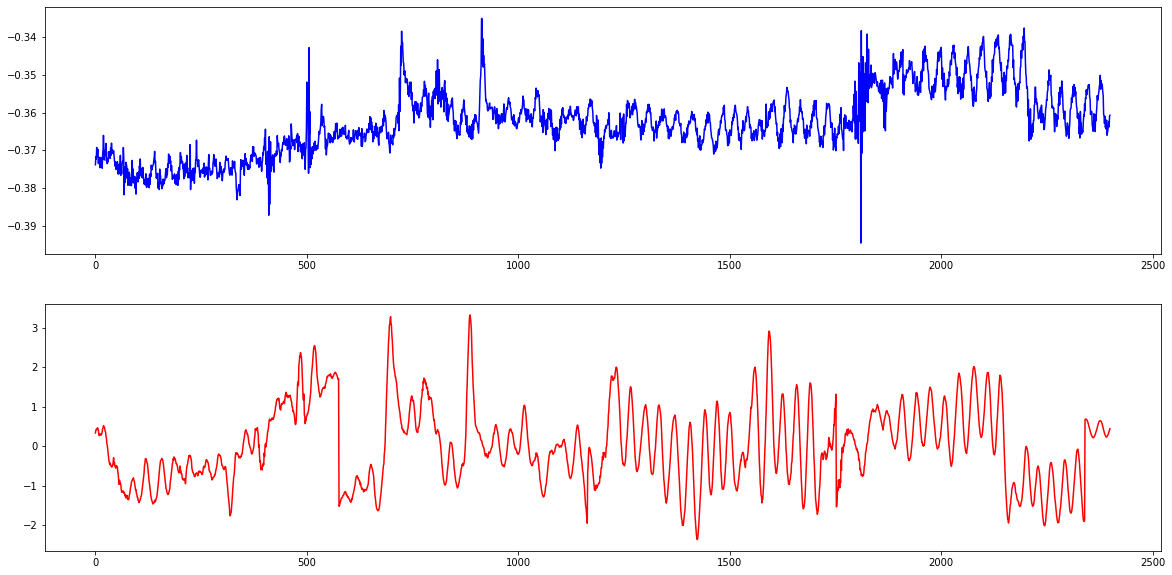

In [10]:

start_ind = 60*10
end_ind = 300*10
x = range(end_ind - start_ind)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

ax1.plot(x, data[start_ind:end_ind], color='b')
ax2.plot(x, moving_data[start_ind:end_ind], color='r')